# Libraries

In [391]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

# Setup

In [392]:
pd.set_option('display.max_rows', 50)

# Load data

In [435]:
data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

print(data.shape)

(100000, 11)


In [ ]:
profile = ProfileReport(data, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

<AxesSubplot:xlabel='Age', ylabel='Count'>

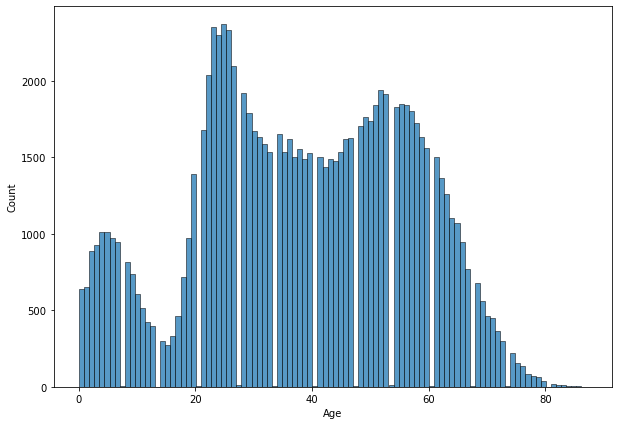

In [436]:
plt.figure(figsize=(10, 7))
sns.histplot(data['Age'], bins=100)

In [437]:
print(data.isnull().sum())

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Fare             134
Cabin          67866
Embarked         250
dtype: int64


## Description of the attributes

* PassengerId - Unique passenger id
* Survived - Flag whether passenger survived or not
* Pclass - Ticket class
* Name - Name of the passenger
* Sex - Gender of the passenger
* Age - Age of the passenger
* SibSp - # of siblings / spouses aboard the Titanic:
    * Siblings: brother, sister, stepbrother, stepsister
    * Spouse: husband, wife (mistresses and fiancés were ignored)
* Parch - # of parents / children aboard the Titanic:
    * Parent: mother, father
    * Child: daughter, son, stepdaughter, stepson
* Ticket - Ticket number
* Fare - Passenger fare
* Cabin - Cabin number
* Embarked - Port of embarkation:
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

In [439]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,100000.000000,100000.000000,100000.000000,100000,100000,96708.000000,100000.000000,100000.000000,99866.00000,32134,99750
unique,NaN,NaN,NaN,92144,2,NaN,NaN,NaN,NaN,26992,3
top,NaN,NaN,NaN,"Johnson, John",male,NaN,NaN,NaN,NaN,C19828,S
freq,NaN,NaN,NaN,31,56114,NaN,NaN,NaN,NaN,6,72139
mean,49999.500000,0.427740,2.106910,NaN,NaN,38.355472,0.397690,0.454560,43.92933,NaN,NaN
std,28867.657797,0.494753,0.837727,NaN,NaN,18.313556,0.862566,0.950076,69.58882,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.080000,0.000000,0.000000,0.68000,NaN,NaN
25%,24999.750000,0.000000,1.000000,NaN,NaN,25.000000,0.000000,0.000000,10.04000,NaN,NaN
50%,49999.500000,0.000000,2.000000,NaN,NaN,39.000000,0.000000,0.000000,24.46000,NaN,NaN
75%,74999.250000,1.000000,3.000000,NaN,NaN,53.000000,1.000000,1.000000,33.50000,NaN,NaN


## Null values

In [440]:
data.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Fare             134
Cabin          67866
Embarked         250
dtype: int64